In [66]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt
from src.utils.imageProcessing import *

# Notebook for combining the tracking and drawing of robot

## Load image

(200, 200)


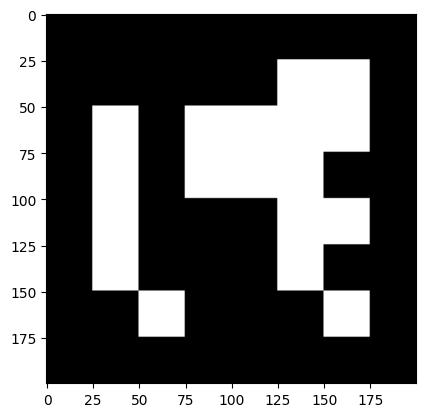

In [67]:
I = cv.imread("./data/raw/img/aruco_marker_1.png", cv.COLOR_BGR2GRAY)
# I = rgb_to_gray(I)
print(I.shape)
plt.imshow(I, cmap="gray")

## Image gradient intensity and NMS 


2922


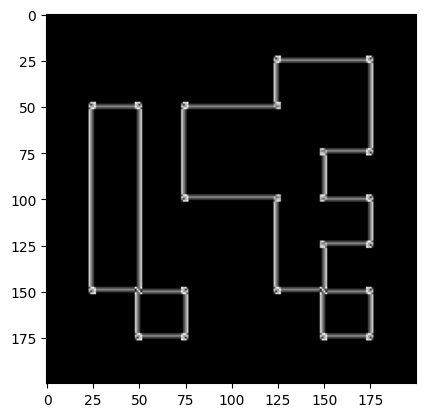

In [68]:

I_blur = gaussian(I, 0.5)

plt.imshow(I_blur, cmap="gray")

Ii = I_blur.copy()

Ix = np.zeros_like(I_blur)
Iy = np.zeros_like(I_blur)

for row in range(I.shape[0]): Ix[row,:] = np.convolve(I_blur[row,:], [1,0,-1], mode='same')
for col in range(I.shape[1]): Ix[:,col] = np.convolve(Ix[:,col], np.array([1,2,1]).T, mode='same')
for row in range(I.shape[0]): Iy[row,:] = np.convolve(I_blur[row,:], [1,2,1], mode='same')
for col in range(I.shape[1]): Iy[:,col] = np.convolve(Iy[:,col], np.array([1,0,-1]), mode='same')

gradient_magnitude = np.sqrt(Ix**2 + Iy**2)
gradient_orientation = np.arctan2(Ix,Iy)

gradient_orientation[(gradient_orientation<22.5)&(gradient_orientation>=0)] = 0
gradient_orientation[(gradient_orientation<67.5)&(gradient_orientation>=22.5)] = 45
gradient_orientation[(gradient_orientation<112.5)&(gradient_orientation>=67.5)] = 90
gradient_orientation[(gradient_orientation<157.5)&(gradient_orientation>=112.5)] = 135
gradient_orientation[(gradient_orientation<=180)&(gradient_orientation>=157.5)] = 0

nms_gradient = np.zeros_like(gradient_magnitude)

for row in range(1, gradient_orientation.shape[0]-1): 
    for col in range(1, gradient_orientation.shape[1]-1): 

        current_pixel_orientation = gradient_orientation[row][col]
        current_pixel_magnitude = gradient_magnitude[row][col]

        if current_pixel_orientation == 0: ## Gradient direction along x-axis and we check to left and right 
            up_pixel = gradient_orientation[row][col+1]
            down_pixel = gradient_orientation[row][col-1]

            if current_pixel_magnitude == np.max((current_pixel_magnitude, up_pixel, down_pixel)): 
                nms_gradient[row][col] = current_pixel_magnitude


        elif current_pixel_orientation == 45: ## gradient direction along 45 degrees and we check diagonal up and down 
            up_pixel = gradient_orientation[row-1][col+1]
            down_pixel = gradient_orientation[row+1][col-1]

            if current_pixel_magnitude == np.max((current_pixel_magnitude, up_pixel, down_pixel)): 
                nms_gradient[row][col] = current_pixel_magnitude

        elif current_pixel_orientation == 90: ## gradient direction along y-axis and we check up and down 
            up_pixel = gradient_orientation[row+1][col]
            down_pixel = gradient_orientation[row-1][col]

            if current_pixel_magnitude == np.max((current_pixel_magnitude, up_pixel, down_pixel)): 
                nms_gradient[row][col] = current_pixel_magnitude

        elif current_pixel_orientation == 135: ## gradient direction along negative 45 degrees and we check diagonal up and down
            up_pixel = gradient_orientation[row+1][col-1]
            down_pixel = gradient_orientation[row-1][col+1]

            if current_pixel_magnitude == np.max((current_pixel_magnitude, up_pixel, down_pixel)): 
                nms_gradient[row][col] = current_pixel_magnitude

indecies = np.nonzero(nms_gradient)
print(len(indecies[0]))

plt.imshow(nms_gradient, cmap="gray")

15.3
2918


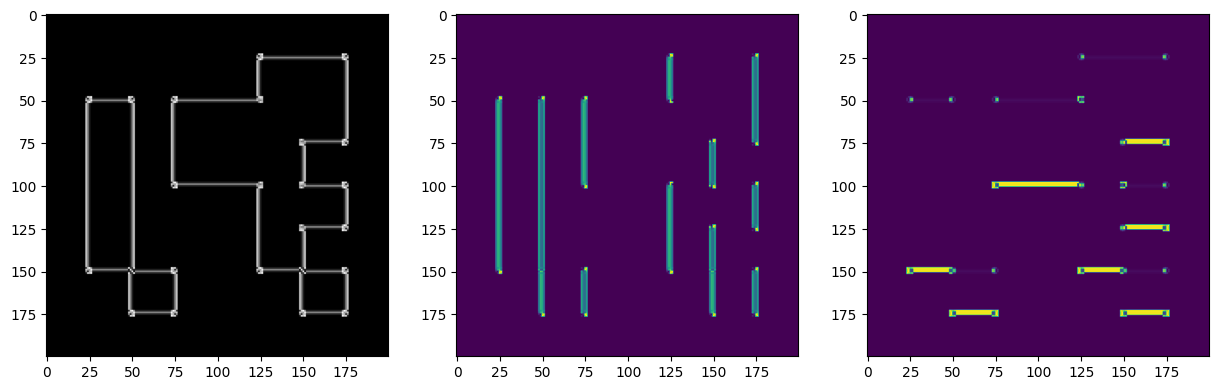

In [69]:
nms_gradient = nms_gradient.copy()
max_value = np.max(nms_gradient)
print(max_value)
upper_thresh = 7
lower_thresh = 2

nms_gradient[nms_gradient<lower_thresh] = 0
nms_gradient[nms_gradient>=upper_thresh] *= 1
nms_gradient[(nms_gradient<=upper_thresh)&(nms_gradient>=lower_thresh)] *= 0.5

indecies = np.nonzero(nms_gradient)
print(len(indecies[0]))

fig = plt.figure(figsize=(15,10))
s1 = fig.add_subplot(1, 3, 1)
s2 = fig.add_subplot(1, 3, 2)
s3 = fig.add_subplot(1, 3, 3)

s1.imshow(nms_gradient, cmap="gray")
s2.imshow(Ix)
s3.imshow(Iy)

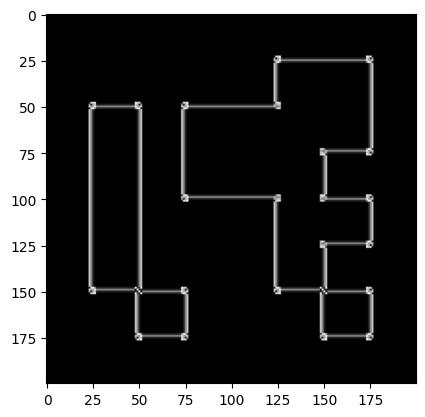

In [70]:
plt.imshow(nms_gradient, cmap="gray")

In [71]:


hysteresis_gradient = nms_gradient.copy()

h, w = hysteresis_gradient.shape

rows, cols = np.nonzero(hysteresis_gradient)

for row, col in zip(rows,cols): 
    if not (h == row or h == col or w == row or h == col or row+1==h or row+1==w or col+1==h or col+1==w): 
        
        max_neighbour = np.max((
            hysteresis_gradient[row-1][col-1],
            hysteresis_gradient[row][col-1],
            hysteresis_gradient[row+1][col-1],
            hysteresis_gradient[row-1][col],
            hysteresis_gradient[row][col],
            hysteresis_gradient[row+1][col],
            hysteresis_gradient[row-1][col+1],
            hysteresis_gradient[row][col+1],
            hysteresis_gradient[row+1][col+1],
        ))

        if max_neighbour>upper_thresh: 
            hysteresis_gradient[row][col] *= 2
        else: 
            hysteresis_gradient[row][col] = 0


print(len(np.nonzero(hysteresis_gradient)[0]))




2918


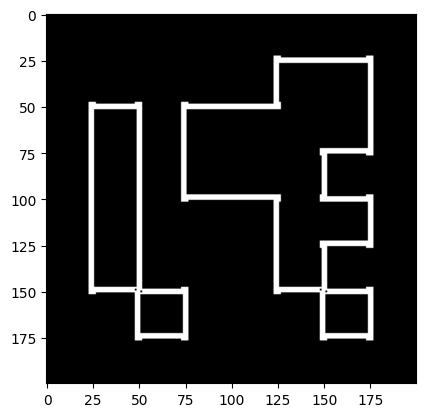

In [72]:

binary = hysteresis_gradient.copy()

binary[binary!=0] = 255

plt.imshow(binary, cmap="gray")